## Project 5: Personal Project 2 - Industrial Defect Data Generation with GAN

In [73]:
%matplotlib inline
import keras
from keras import initializers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import LeakyReLU, Dropout
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.datasets import mnist
import numpy as np
from PIL import Image
import argparse
import math
import glob
import cv2
import matplotlib.pyplot as plt

### Step 1: Import & preprocess training images

In [74]:
img_list = []

for img in glob.glob('crop/*.PNG'):
    input_img = cv2.imread(img,0)
    input_img = cv2.resize(input_img,(28,28))
    img_list.append(input_img)

X_train = np.array(img_list)
X_train = X_train.reshape(-1, 28, 28, 1).astype(np.float32)
X_train = (X_train - 127.5) / 127.5 # Normalize dataset

print(X_train.shape)

(100, 28, 28, 1)


In [77]:
def show_img(img):
    image = img.reshape([28,28])
    fig, axes = plt.subplots(1, )
    fig.subplots_adjust(hspace=2, wspace=2)
    plt.imshow(image, cmap='gray')
    plt.show()

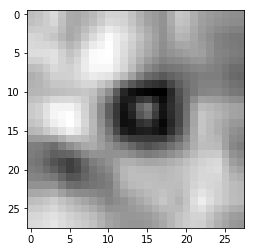

In [78]:
show_img(X_train[50])

### Step 2: Setup the generator model

In [64]:
def generator_model():
    model = Sequential()
    model.add(Dense(7*7*50, input_dim=100))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Reshape((7, 7, 50)))
    model.add(Conv2DTranspose(20, (5,5), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Conv2DTranspose(1, (5,5), strides=2, padding='same'))
    model.add(Activation('tanh'))
    
    model.summary()
    return model

### Step 3: Setup the discriminator medol

In [65]:
def discriminator_model():
    model = Sequential()
    model.add(Conv2D(20, (5, 5), strides=2, padding='same', input_shape=(28, 28, 1)))
    model.add(Activation('tanh'))
    model.add(Conv2D(50, (5, 5), strides=2, padding='same'))
    model.add(Activation('tanh'))
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.summary()
    return model

### Step 4: Setup generator on discriminator

In [66]:
def generator_containing_discriminator(generator, discriminator):
    model = Sequential()
    model.add(generator)
    d.trainable = False
    model.add(discriminator)
    return model

### Step 5: Combine the models

In [67]:
d = discriminator_model()
g = generator_model()
d_on_g = generator_containing_discriminator(g, d)
d_optim = SGD(lr=0.001, momentum=0.9, nesterov=True)
g_optim = SGD(lr=0.001, momentum=0.9, nesterov=True)
g.compile(loss='binary_crossentropy', optimizer="SGD")
d_on_g.compile(loss='binary_crossentropy', optimizer=g_optim)
d.trainable = True
d.compile(loss='binary_crossentropy', optimizer=d_optim)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 14, 14, 20)        520       
_________________________________________________________________
activation_64 (Activation)   (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 50)          25050     
_________________________________________________________________
activation_65 (Activation)   (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2450)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 500)               1225500   
_________________________________________________________________
activation_66 (Activation)   (None, 500)               0         
__________

### Step 6: Combine images into batch

In [68]:
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

### Step 7: Train the model

In [70]:
BATCH_SIZE = 100

for epoch in range(1000):
    for index in range(int(X_train.shape[0]/BATCH_SIZE)):
        noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, 100))
        image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
        generated_images = g.predict(noise, verbose=0)
        image = combine_images(generated_images)
        image = image*127.5+127.5
        X = np.concatenate((image_batch, generated_images))
        y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
        d_loss = d.train_on_batch(X, y)
        noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
        d.trainable = False
        g_loss = d_on_g.train_on_batch(noise, [1] * BATCH_SIZE)
        d.trainable = True
            
        print("Epochs: %03d   Discriminator Loss: %f   Generator Loss : %f" % (epoch, d_loss, g_loss))
            
        g.save_weights('generator', True)
        d.save_weights('discriminator', True)

Epochs: 000   Discriminator Loss: 0.227449   Generator Loss : 0.620099
Epochs: 001   Discriminator Loss: 0.223384   Generator Loss : 0.576651
Epochs: 002   Discriminator Loss: 0.220596   Generator Loss : 0.576731
Epochs: 003   Discriminator Loss: 0.214991   Generator Loss : 0.580377
Epochs: 004   Discriminator Loss: 0.214034   Generator Loss : 0.542576
Epochs: 005   Discriminator Loss: 0.210203   Generator Loss : 0.538682
Epochs: 006   Discriminator Loss: 0.209696   Generator Loss : 0.589430
Epochs: 007   Discriminator Loss: 0.210135   Generator Loss : 0.579536
Epochs: 008   Discriminator Loss: 0.210307   Generator Loss : 0.546802
Epochs: 009   Discriminator Loss: 0.215388   Generator Loss : 0.496533
Epochs: 010   Discriminator Loss: 0.215879   Generator Loss : 0.464431
Epochs: 011   Discriminator Loss: 0.215629   Generator Loss : 0.444541
Epochs: 012   Discriminator Loss: 0.227348   Generator Loss : 0.440248
Epochs: 013   Discriminator Loss: 0.225384   Generator Loss : 0.445972
Epochs

Epochs: 116   Discriminator Loss: 1.203616   Generator Loss : 0.808271
Epochs: 117   Discriminator Loss: 1.241997   Generator Loss : 0.794476
Epochs: 118   Discriminator Loss: 1.286598   Generator Loss : 0.863918
Epochs: 119   Discriminator Loss: 1.299381   Generator Loss : 0.914841
Epochs: 120   Discriminator Loss: 1.329850   Generator Loss : 0.975147
Epochs: 121   Discriminator Loss: 1.325150   Generator Loss : 1.004897
Epochs: 122   Discriminator Loss: 1.315470   Generator Loss : 1.026089
Epochs: 123   Discriminator Loss: 1.314591   Generator Loss : 1.097106
Epochs: 124   Discriminator Loss: 1.289183   Generator Loss : 1.137335
Epochs: 125   Discriminator Loss: 1.251190   Generator Loss : 1.139922
Epochs: 126   Discriminator Loss: 1.229735   Generator Loss : 1.168500
Epochs: 127   Discriminator Loss: 1.193658   Generator Loss : 1.178087
Epochs: 128   Discriminator Loss: 1.149426   Generator Loss : 1.214939
Epochs: 129   Discriminator Loss: 1.111657   Generator Loss : 1.218879
Epochs

Epochs: 232   Discriminator Loss: 1.086797   Generator Loss : 0.386348
Epochs: 233   Discriminator Loss: 1.164355   Generator Loss : 0.349274
Epochs: 234   Discriminator Loss: 1.200008   Generator Loss : 0.371581
Epochs: 235   Discriminator Loss: 1.244648   Generator Loss : 0.376355
Epochs: 236   Discriminator Loss: 1.287984   Generator Loss : 0.364110
Epochs: 237   Discriminator Loss: 1.300392   Generator Loss : 0.395924
Epochs: 238   Discriminator Loss: 1.316369   Generator Loss : 0.405430
Epochs: 239   Discriminator Loss: 1.316893   Generator Loss : 0.448474
Epochs: 240   Discriminator Loss: 1.313967   Generator Loss : 0.427177
Epochs: 241   Discriminator Loss: 1.301367   Generator Loss : 0.437245
Epochs: 242   Discriminator Loss: 1.272388   Generator Loss : 0.458766
Epochs: 243   Discriminator Loss: 1.243482   Generator Loss : 0.506736
Epochs: 244   Discriminator Loss: 1.208478   Generator Loss : 0.506769
Epochs: 245   Discriminator Loss: 1.167867   Generator Loss : 0.544986
Epochs

Epochs: 349   Discriminator Loss: 0.503294   Generator Loss : 0.912470
Epochs: 350   Discriminator Loss: 0.491516   Generator Loss : 0.911713
Epochs: 351   Discriminator Loss: 0.480195   Generator Loss : 0.900812
Epochs: 352   Discriminator Loss: 0.469485   Generator Loss : 0.898592
Epochs: 353   Discriminator Loss: 0.460413   Generator Loss : 0.879099
Epochs: 354   Discriminator Loss: 0.449581   Generator Loss : 0.853261
Epochs: 355   Discriminator Loss: 0.438107   Generator Loss : 0.864776
Epochs: 356   Discriminator Loss: 0.430819   Generator Loss : 0.816061
Epochs: 357   Discriminator Loss: 0.420670   Generator Loss : 0.807361
Epochs: 358   Discriminator Loss: 0.410338   Generator Loss : 0.838013
Epochs: 359   Discriminator Loss: 0.403091   Generator Loss : 0.815495
Epochs: 360   Discriminator Loss: 0.394879   Generator Loss : 0.802934
Epochs: 361   Discriminator Loss: 0.384369   Generator Loss : 0.793059
Epochs: 362   Discriminator Loss: 0.375184   Generator Loss : 0.792430
Epochs

Epochs: 466   Discriminator Loss: 0.616839   Generator Loss : 0.682783
Epochs: 467   Discriminator Loss: 0.663837   Generator Loss : 0.700004
Epochs: 468   Discriminator Loss: 0.716230   Generator Loss : 0.720744
Epochs: 469   Discriminator Loss: 0.794258   Generator Loss : 0.689936
Epochs: 470   Discriminator Loss: 0.854625   Generator Loss : 0.699558
Epochs: 471   Discriminator Loss: 0.895898   Generator Loss : 0.707573
Epochs: 472   Discriminator Loss: 0.977796   Generator Loss : 0.731622
Epochs: 473   Discriminator Loss: 1.025719   Generator Loss : 0.722562
Epochs: 474   Discriminator Loss: 1.061468   Generator Loss : 0.751086
Epochs: 475   Discriminator Loss: 1.124872   Generator Loss : 0.760147
Epochs: 476   Discriminator Loss: 1.178228   Generator Loss : 0.746534
Epochs: 477   Discriminator Loss: 1.220603   Generator Loss : 0.766115
Epochs: 478   Discriminator Loss: 1.238506   Generator Loss : 0.810606
Epochs: 479   Discriminator Loss: 1.272213   Generator Loss : 0.784818
Epochs

Epochs: 583   Discriminator Loss: 0.648816   Generator Loss : 0.318694
Epochs: 584   Discriminator Loss: 0.680760   Generator Loss : 0.337704
Epochs: 585   Discriminator Loss: 0.744933   Generator Loss : 0.338508
Epochs: 586   Discriminator Loss: 0.800701   Generator Loss : 0.357688
Epochs: 587   Discriminator Loss: 0.853279   Generator Loss : 0.351659
Epochs: 588   Discriminator Loss: 0.907466   Generator Loss : 0.353975
Epochs: 589   Discriminator Loss: 0.973313   Generator Loss : 0.378955
Epochs: 590   Discriminator Loss: 1.014011   Generator Loss : 0.391067
Epochs: 591   Discriminator Loss: 1.059942   Generator Loss : 0.424006
Epochs: 592   Discriminator Loss: 1.122438   Generator Loss : 0.439845
Epochs: 593   Discriminator Loss: 1.166732   Generator Loss : 0.458218
Epochs: 594   Discriminator Loss: 1.192676   Generator Loss : 0.525516
Epochs: 595   Discriminator Loss: 1.204008   Generator Loss : 0.485164
Epochs: 596   Discriminator Loss: 1.199724   Generator Loss : 0.492354
Epochs

Epochs: 699   Discriminator Loss: 0.259810   Generator Loss : 0.570693
Epochs: 700   Discriminator Loss: 0.255236   Generator Loss : 0.556079
Epochs: 701   Discriminator Loss: 0.249259   Generator Loss : 0.542054
Epochs: 702   Discriminator Loss: 0.239532   Generator Loss : 0.526929
Epochs: 703   Discriminator Loss: 0.235648   Generator Loss : 0.532561
Epochs: 704   Discriminator Loss: 0.234880   Generator Loss : 0.524056
Epochs: 705   Discriminator Loss: 0.228250   Generator Loss : 0.500291
Epochs: 706   Discriminator Loss: 0.225070   Generator Loss : 0.507985
Epochs: 707   Discriminator Loss: 0.220521   Generator Loss : 0.456788
Epochs: 708   Discriminator Loss: 0.217461   Generator Loss : 0.475053
Epochs: 709   Discriminator Loss: 0.215196   Generator Loss : 0.448363
Epochs: 710   Discriminator Loss: 0.213024   Generator Loss : 0.450072
Epochs: 711   Discriminator Loss: 0.211971   Generator Loss : 0.437057
Epochs: 712   Discriminator Loss: 0.210344   Generator Loss : 0.432751
Epochs

Epochs: 816   Discriminator Loss: 0.988667   Generator Loss : 1.219902
Epochs: 817   Discriminator Loss: 0.905989   Generator Loss : 1.202803
Epochs: 818   Discriminator Loss: 0.832445   Generator Loss : 1.198311
Epochs: 819   Discriminator Loss: 0.772548   Generator Loss : 1.189038
Epochs: 820   Discriminator Loss: 0.718065   Generator Loss : 1.195822
Epochs: 821   Discriminator Loss: 0.669538   Generator Loss : 1.186547
Epochs: 822   Discriminator Loss: 0.625476   Generator Loss : 1.160104
Epochs: 823   Discriminator Loss: 0.585856   Generator Loss : 1.147271
Epochs: 824   Discriminator Loss: 0.550009   Generator Loss : 1.102162
Epochs: 825   Discriminator Loss: 0.516905   Generator Loss : 1.066172
Epochs: 826   Discriminator Loss: 0.488264   Generator Loss : 1.042834
Epochs: 827   Discriminator Loss: 0.461316   Generator Loss : 1.011183
Epochs: 828   Discriminator Loss: 0.437709   Generator Loss : 0.958924
Epochs: 829   Discriminator Loss: 0.416498   Generator Loss : 0.935532
Epochs

Epochs: 933   Discriminator Loss: 0.361760   Generator Loss : 1.012986
Epochs: 934   Discriminator Loss: 0.347167   Generator Loss : 0.984128
Epochs: 935   Discriminator Loss: 0.331247   Generator Loss : 0.972274
Epochs: 936   Discriminator Loss: 0.317962   Generator Loss : 0.948110
Epochs: 937   Discriminator Loss: 0.306025   Generator Loss : 0.910141
Epochs: 938   Discriminator Loss: 0.296799   Generator Loss : 0.905141
Epochs: 939   Discriminator Loss: 0.286174   Generator Loss : 0.914986
Epochs: 940   Discriminator Loss: 0.282107   Generator Loss : 0.916543
Epochs: 941   Discriminator Loss: 0.273110   Generator Loss : 0.840420
Epochs: 942   Discriminator Loss: 0.269487   Generator Loss : 0.845809
Epochs: 943   Discriminator Loss: 0.267312   Generator Loss : 0.818461
Epochs: 944   Discriminator Loss: 0.267563   Generator Loss : 0.750170
Epochs: 945   Discriminator Loss: 0.266280   Generator Loss : 0.800327
Epochs: 946   Discriminator Loss: 0.273238   Generator Loss : 0.757702
Epochs

### Step 8: Let's try to use the generator to generate dataset

In [81]:
def generate(BATCH_SIZE, nice=False):
    g = generator_model()
    g.compile(loss='binary_crossentropy', optimizer="SGD")
    g.load_weights('generator')
    if nice:
        d = discriminator_model()
        d.compile(loss='binary_crossentropy', optimizer="SGD")
        d.load_weights('discriminator')
        noise = np.random.uniform(-1, 1, (BATCH_SIZE*20, 100))
        generated_images = g.predict(noise, verbose=1)
        d_pret = d.predict(generated_images, verbose=1)
        index = np.arange(0, BATCH_SIZE*20)
        index.resize((BATCH_SIZE*20, 1))
        pre_with_index = list(np.append(d_pret, index, axis=1))
        pre_with_index.sort(key=lambda x: x[0], reverse=True)
        nice_images = np.zeros((BATCH_SIZE,) + generated_images.shape[1:3], dtype=np.float32)
        nice_images = nice_images[:, :, :, None]
        for i in range(BATCH_SIZE):
            idx = int(pre_with_index[i][1])
            nice_images[i, :, :, 0] = generated_images[idx, :, :, 0]
        image = combine_images(nice_images)
    else:
        noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
        generated_images = g.predict(noise, verbose=0)
        image = combine_images(generated_images)
    image = image*127.5+127.5
    Image.fromarray(image.astype(np.uint8)).save(
        "generated_image.png")
    show_img(generated_images[50])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 2450)              247450    
_________________________________________________________________
batch_normalization_33 (Batc (None, 2450)              9800      
_________________________________________________________________
activation_77 (Activation)   (None, 2450)              0         
_________________________________________________________________
reshape_17 (Reshape)         (None, 7, 7, 50)          0         
_________________________________________________________________
conv2d_transpose_33 (Conv2DT (None, 14, 14, 20)        25020     
_________________________________________________________________
batch_normalization_34 (Batc (None, 14, 14, 20)        80        
_________________________________________________________________
activation_78 (Activation)   (None, 14, 14, 20)        0         
__________

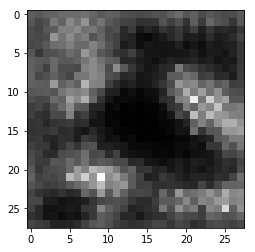

In [82]:
generate(BATCH_SIZE)